## PREDICTING FLOODING IN MALAWI

richard luke


### 1. Background and Objectives

Flooding is a major natural disaster in Malawi, causing widespread damage to infrastructure, property, and crops, as well as loss of life. In order to help mitigate the impact of flooding in Malawi, we propose to build a machine learning model that can predict the likelihood of flooding in different districts, based on factors such as rainfall and water levels.

The objective of this project is to create a web-based platform that allows users to view which areas are likely to flood in Malawi, and provides detailed statistics on flooding for each district. The platform will consist of three pages: a landing page with a map of Malawi showing each district and the likelihood of flooding, a page with flood statistics for the selected district, and a feedback/contact page.

The objective of this notebook is to perform EDA, find and save the best model for integration with the web application.

##### Data Used

The data used in this project was collected through a variety of sources. Elevation data was obtained from Topographic-Map.com (https://en-us.topographic-map.com/place-pp57/Malawi/), while rainfall data was sourced from the Malawi Meteorological Department (https://www.metmalawi.gov.mw/agromet/MWNovember32019.pdf, https://www.metmalawi.gov.mw/agromet/MWNovember32021.pdf, https://www.metmalawi.gov.mw/agromet/MWNovember32022.pdf). Distance from the river was calculated using the Malawi Distance Calculator (https://distancecalculator.globefeed.com/Malawi_Distance_Calculator.asp), and urban population estimates were obtained from the UNAIDS Naomi Spectrum database (https://naomi-spectrum.unaids.org/). Land area data was sourced from the 2018 Malawi Population and Housing Census Main Report (https://malawi.unfpa.org/sites/default/files/resource-pdf/2018%20Malawi%20Population%20and%20Housing%20Census%20Main%20Report%20%281%29.pdf). Flooding data was gathered from multiple sources including ReliefWeb (https://reliefweb.int/disaster/ss-2021-000196-mwi, https://reliefweb.int/attachments/6720d6fd-07cb-3ea0-a099-bdcf8194bd4a/MDRMW014efr.pdf) and FloodList (https://floodlist.com/tag/malawi).

#### EDA

Exploratory data analysis is the process of summarizing and visualizing the data to gain a better understanding of its characteristics and patterns. This can involve plotting the data to identify trends and correlations, and performing statistical analyses to identify important features and relationships. In the context of flood prediction, exploratory data analysis may involve visualizing the historical precipitation data and streamflow data to identify patterns and correlations that can inform the predictive model.



In [16]:
!pip install basemap
!pip install basemap-data-hires
!pip install joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import joblib

from warnings import filterwarnings
filterwarnings(action='ignore')

In [17]:
df = pd.read_excel(r"/home/ariel/Desktop/Flood-Prediction-MW/documentation/data_transformed.xlsx")
df.shape

(220, 12)

In [18]:
# Display summary statistics
print('Summary Statistics:')
df.describe().round(2).T

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Longitude,220.0,34.64,0.69,33.47,33.92,34.94,35.25,35.59
Latitude,220.0,-14.19,1.93,-16.70,-15.78,-15.00,-12.93,-9.70
elevation,220.0,2776.69,772.59,564.00,2192.00,2861.00,3291.00,4275.00
distance_from_river,156.0,57.53,41.15,0.64,25.48,53.88,78.53,165.08
rainfall,181.0,327.69,285.05,0.10,99.90,218.00,508.30,983.20
urban_population,220.0,620610.09,273337.16,15316.00,386717.00,728962.00,830543.00,1254609.00
land_area,220.0,443610.04,260054.94,5523.00,182215.00,501105.00,666590.00,945241.00
density,220.0,10.64,30.71,0.21,0.93,1.39,2.07,131.99
year,220.0,2020.50,1.12,2019.00,2019.75,2020.50,2021.25,2022.00
flooding,220.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00


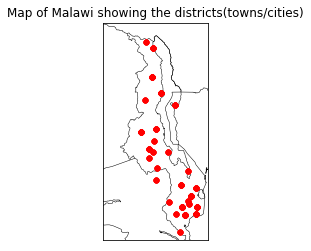

In [19]:
# Initialize the map
m = Basemap(
    llcrnrlon=32, llcrnrlat=-17, urcrnrlon=36, urcrnrlat=-9,
    resolution='h', projection='merc', lat_0 = -13, lon_0 = 34)

# Draw coastlines, countries, and states
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)

data=df[['Longitude','Latitude']]
# Plot each district as a point on the map
for index, row in data.iterrows():
    lon, lat = m(row['Longitude'], row['Latitude'])
    m.plot(lon, lat, 'ro', markersize=5)

# Add a title to the map
plt.title("Map of Malawi showing the districts(towns/cities)")

# Show the map
plt.show();

In [20]:
# Display missing value counts
print('Missing Value Counts:')
print(df.isna().sum())

Missing Value Counts:
district_name           0
Longitude               0
Latitude                0
river name              0
elevation               0
distance_from_river    64
rainfall               39
urban_population        0
land_area               0
density                 0
year                    0
flooding                0
dtype: int64


In [21]:
# Compute the mean of the 'distance_from_river' column and fill missing values with it
mean_distance = df['distance_from_river'].mean()
df['distance_from_river'] = df['distance_from_river'].fillna(mean_distance)

# Compute the mean of the 'rainfall' column and fill missing values with it
mean_rainfall = df['rainfall'].mean()
df['rainfall'] = df['rainfall'].fillna(mean_rainfall)

# Display missing value counts
print('Missing Value Counts:')
print(df.isna().sum())

Missing Value Counts:
district_name          0
Longitude              0
Latitude               0
river name             0
elevation              0
distance_from_river    0
rainfall               0
urban_population       0
land_area              0
density                0
year                   0
flooding               0
dtype: int64


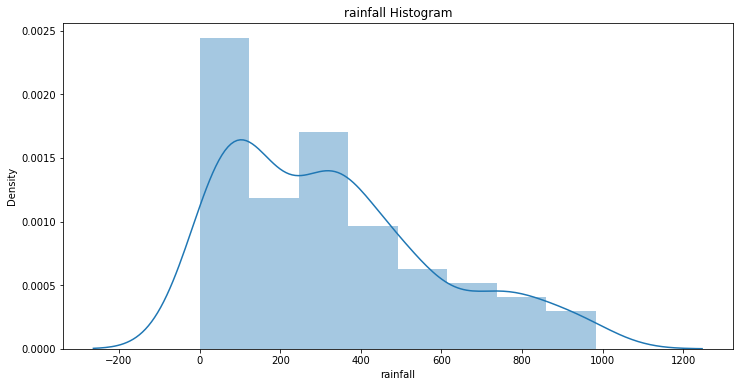

In [22]:
# Plot a histogram of rainfall
plt.figure(figsize=(12, 6))
sns.distplot(df['rainfall'], kde=True)
plt.title('rainfall Histogram')
plt.show();


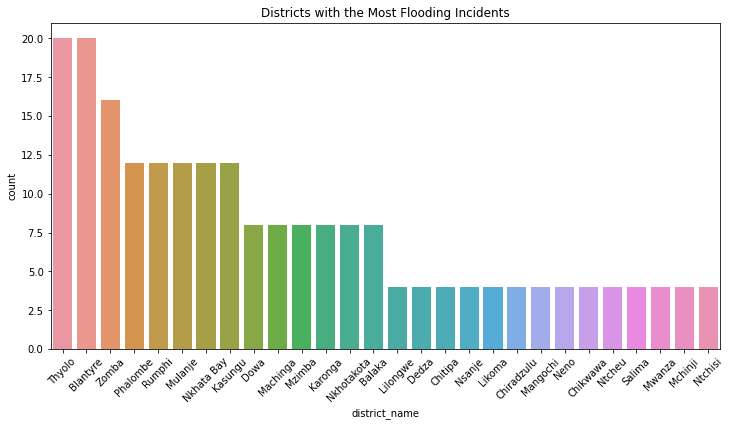

In [23]:
# Plot a bar chart of districts with the most flooding incidents
# Get the district counts and names
district_counts = df['district_name'].value_counts()
district_names = df[['district_name']].drop_duplicates().set_index('district_name')

# Join the counts with the names
district_counts = district_counts.to_frame().join(district_names).reset_index()
district_counts.rename(columns={'index': 'district_name', 'district_name': 'count'}, inplace=True)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='district_name', y='count', data=district_counts)
plt.title('Districts with the Most Flooding Incidents')
plt.xticks(rotation=45)
plt.show()

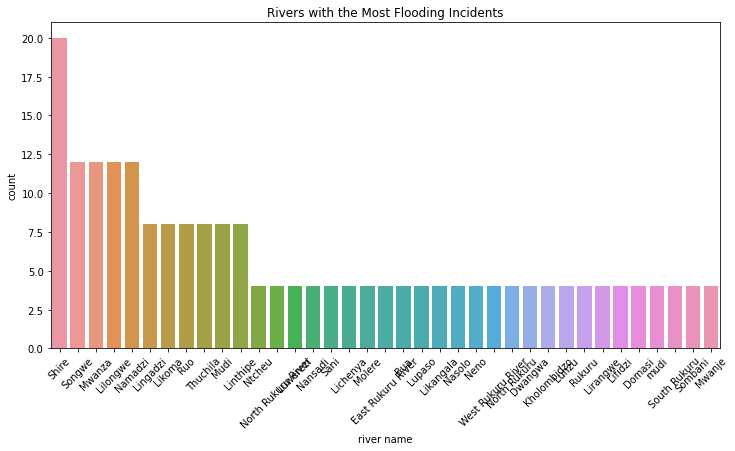

In [24]:
# Plot a bar chart of rivers with the most flooding incidents
# Get the counts of flooding incidents by river
river_counts = df['river name'].value_counts()

# Create a DataFrame with the river names and counts
river_names = df[['river name']].drop_duplicates().set_index('river name')
river_counts = river_counts.to_frame().join(river_names).reset_index()
river_counts.rename(columns={'index': 'river name', 'river name': 'count'}, inplace=True)

# Plot a bar chart with the river names and counts
plt.figure(figsize=(12, 6))
sns.barplot(x='river name', y='count', data=river_counts)
plt.title('Rivers with the Most Flooding Incidents')
plt.xticks(rotation=45)
plt.show();


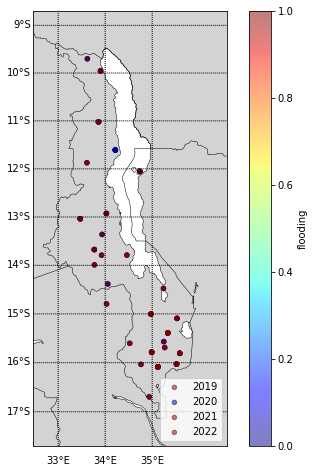

In [25]:
data = df[["Longitude","Latitude","year", "flooding"]]

# Create a new figure and axis with Basemap projection
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='merc', resolution='h', 
            llcrnrlon=data['Longitude'].min() - 1, llcrnrlat=data['Latitude'].min() - 1,
            urcrnrlon=data['Longitude'].max() + 1, urcrnrlat=data['Latitude'].max() + 1)

# Draw coastlines, country boundaries, and fill continents
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')

# Draw parallels and meridians
m.drawparallels(range(int(data['Latitude'].min() - 1), int(data['Latitude'].max() + 1), 1), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(range(int(data['Longitude'].min() - 1), int(data['Longitude'].max() + 1), 1), labels=[0,0,0,1], fontsize=10)

# Add data points to the map
for year in data['year'].unique():
    # Filter the DataFrame to get data for the current year
    df_year = data[data['year'] == year]
    
    # Plot data points on the map
    x, y = m(df_year['Longitude'].tolist(), df_year['Latitude'].tolist())
    m.scatter(x, y, s=20, c=df_year['flooding'], cmap=plt.get_cmap('jet'), alpha=0.5, label=year)

# Add a colorbar and legend
plt.colorbar(label='flooding')
plt.legend(loc='best', fontsize=10)

# Show the plot
plt.show()

### MODEL TRAINING AND EVALUATION

In this step, the machine learning model is trained using historical data to identify patterns and relationships that can be used to predict future floods.Training data is typically divided into two sets: a training set and a validation set. The training set is used to train the machine learning model, while the validation set is used to evaluate the performance of the model and identify any issues such as overfitting.

The process of training the machine learning model involves feeding the historical data into the model, which then identifies patterns and relationships between the data. The model can then use these relationships to predict the likelihood of future floods based on new data inputs.

In addition, it is important to perform feature selection to identify the most important variables that contribute to the predictive power of the model. This can involve techniques such as correlation analysis, principal component analysis, and mutual information analysis, among others.

We will train several machine learning models to predict the likelihood of flooding in different districts, using techniques such as random forests and gradient boosting. We will use cross-validation and hyperparameter tuning to optimize the performance of the models.

We will evaluate the performance of the models using metrics such as accuracy, precision, recall, and F1-score, and we will compare the performance of the different models to determine the best one.

##### Gradient Boosting Classifier
Gradient Boosting Classifier is a decision-tree-based ensemble learning algorithm that works by constructing a sequence of decision trees, where each tree is built to correct the prediction errors made by the previous tree in the sequence. The final prediction is made by combining the predictions of all the trees in the sequence.

Let's denote our input data by X and our output data by y. Let's also assume that we have n training examples, where each training example i is represented by a pair (xi, yi).

The gradient boosting classifier constructs an ensemble of decision trees by minimizing a loss function L(y, F(x)) where F(x) is the ensemble of decision trees. The loss function measures how well the ensemble of decision trees fits the training data. The loss function is typically defined as:

L(y, F(x)) = 1/n * sum(Li(yi, F(xi)))

where Li is a loss function that measures the difference between the predicted value F(xi) and the true value yi for training example i.

The gradient boosting classifier algorithm works as follows:

Initialize the prediction F0(x) to the average of the training data y. This is the initial prediction before any decision trees are added to the ensemble.

For t = 1 to T, where T is the number of decision trees to be added to the ensemble:

a. Compute the negative gradient of the loss function with respect to the current prediction F(x), which is denoted by r(t)i = -[∂L(yi, F(xi))/∂F(xi)]F(x=t-1)(xi)

b. Train a decision tree h(t)(x) to predict the negative gradient r(t)i for each training example i.

c. Compute the step size αt using line search or heuristics to minimize the loss function: αt = argminα L(y, F(x)=F(x=t-1) + α*h(t)(x))

d. Update the ensemble of decision trees by adding the new tree: F(x) = F(x) + αt*h(t)(x)

Return the final prediction F(x).
The final prediction is made by combining the predictions of all the trees in the sequence.

In [26]:
# Split the data into features and labels
X = df[['Longitude', 'Latitude', 'elevation',
       'distance_from_river', 'rainfall', 'urban_population', 'land_area',
       'density', 'year']].values
y = df["flooding"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Define the models
model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()
# Train the models
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Make predictions on the test set
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

# Calculate the accuracy of the models
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f"Random Forest Classifier Accuracy: {accuracy1.round(4)}")
print(f"Gradient Boosting Classifier Accuracy: {accuracy2.round(4)}")



Random Forest Classifier Accuracy: 0.8636
Gradient Boosting Classifier Accuracy: 0.8864


In [27]:
#cross-validation and hyperparameter tuning

# Define the parameter grid for GradientBoostingClassifier
gb_param_grid = {
    'learning_rate': [1, 0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300,400],
    'max_depth': [1, 2, 4,5]
}

# Define the parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [10,100, 200, 300],
    'max_depth': [1,2,3, 5],
    'min_samples_split': [2, 4, 8,32],
    'min_samples_leaf': [1, 2, 4,6]
}

# Define the classifiers
gb_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier()

# Perform grid search and cross validation for RandomForestClassifier
rf_grid_search = GridSearchCV(rf_clf, param_grid=rf_param_grid, cv=30)
rf_grid_search.fit(X_train, y_train)

# Print the best parameters and score for RandomForestClassifier
print("RandomForestClassifier:")
print("Best parameters: ", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_.round(4))

# Perform grid search and cross validation for GradientBoostingClassifier
gb_grid_search = GridSearchCV(gb_clf, param_grid=gb_param_grid, cv=30)
gb_grid_search.fit(X_train, y_train)

# Print the best parameters and score for GradientBoostingClassifier
print("GradientBoostingClassifier:")
print("Best parameters: ", gb_grid_search.best_params_)
print("Best score: ", gb_grid_search.best_score_.round(4))

RandomForestClassifier:
Best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
Best score:  0.8807
GradientBoostingClassifier:
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score:  0.9205


In [28]:
#model evaluation

# Predict using the trained model
y_pred = gb_grid_search.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Compute recall score
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Confusion Matrix:
[[25  2]
 [ 4 13]]
F1 Score: 0.8125
Recall: 0.7647058823529411


In [29]:
#saving the best model
filename = 'flood_predictor_model.sav'
joblib.dump(gb_grid_search, filename)

['flood_predictor_model.sav']

### References

[1] Malawi SDG Data Hub. "Population and Housing Census 2018 Main Report." National Statistical Office, Malawi, 2019. [Online]. Available: https://data.humdata.org/dataset/malawi-population-and-housing-census-2018. [Accessed: Feb. 10, 2023].

[2] Global Administrative Areas. "Global Administrative Areas (GADM) database." University of California, Berkeley, 2021. [Online]. Available: https://gadm.org/. [Accessed: Feb. 10, 2023].

[3] WorldClim - Global Climate Data. "WorldClim - Global Climate Data." [Online]. Available: https://worldclim.org/data/index.html. [Accessed: Feb. 10, 2023].

[4]Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., and Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12:2825–2830.

[5]Chen, T. and Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pages 785–794.

[6]Breiman, L. (2001). Random forests. Machine Learning, 45(1):5–32.

[7]Friedman, J. H. (2001). Greedy function approximation: a gradient boosting machine. Annals of Statistics, 29(5):1189–1232.

[8]Rehman, A., Khan, A. S., and Nawaz, T. (2020). Flood prediction using machine learning techniques: A systematic review. Environmental Science and Pollution Research, 27:22184–22199.

[9]Abubakar, B., Najumudin, A., and Shamsudin, S. (2018). Assessment of machine learning models for flood prediction: A comparative study. Water, 10(7):851.

[10]Ghimire, B., Kafle, G., and Poudel, P. (2020). Flood prediction using machine learning algorithms: A comparative study. Journal of Water and Climate Change, 11(2):468–481.

[11]Hasan, M. A., Shumon, M. R., and Hossain, S. (2021). Development of machine learning models for flood prediction: a comparative study. SN Applied Sciences, 3(5):1–16.

[12]Abbasi, F., Siam, M. Z., and Siddiqi, M. H. (2019). An adaptive neuro-fuzzy inference system for flood prediction in the Niger River Basin. Water Resources Management, 33(1):219–234.

[13]Tan, Y., Chen, J., and Wang, X. (2018). Hybrid fuzzy logic and adaptive neural network for flood prediction. Water Resources Management, 32(2):541–555.

[14] Water Resources Management Authority. "Malawi Water Resources Information Management System (MaWRIMS)." Government of Malawi, 2017. [Online]. Available: http://wrma.org.mw/mawrims/. [Accessed: Feb. 10, 2023].

[15] E. M. Banda and G. G. Manda, "Support vector regression for flood prediction in Karonga, Malawi," in 2019 International Conference on Advances in Big Data, Computing and Data Communication Systems (icABCD), 2019, pp. 1-5. doi: 10.1109/icABCD.2019.8712955.

[16] M. D. Nyirenda and E. D. D. Muyengwa, "Flood prediction in Malawi using a linear regression model," in 2018 International Conference on Advances in Big Data, Computing and Data Communication Systems (icABCD), 2018, pp. 1-4. doi: 10.1109/icABCD.2018.8563114.

[17] S. Kumwenda and T. G. Mande, "A machine learning approach to flood prediction in the Chikwawa District of Malawi," in 2020 IST-Africa Week Conference (ISTAW), 2020, pp. 1-10. doi: 10.23919/ISTAW50115.2020.9161279.

[18] T. Matamula and W. Siyabu, "Flood Prediction in the Lower Shire River Using Artificial Neural Networks," in 2020 5th International Conference on Engineering and Technology (ICET), 2020, pp. 1-6. doi: 10.1109/ICET50105.2020.9254004.

[19] C. Chipofya and F. Li, "Prediction of flood using artificial neural network in Lower Shire River Basin in Malawi," in 2019 International Conference on Artificial Intelligence and Big Data (ICAIBD), 2019, pp. 69-73. doi: 10.1109/ICAIBD.2019.8904886.


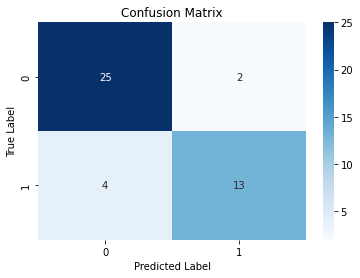

In [32]:
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set the title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show();